Работу выполнила Мария Минина, БКЛ221

**Вариант 14**

Ресурс: [stopgame.ru](https://stopgame.ru/)

Задание: *Две новости считаются похожими, если косинусная мера сходства между ними выше заданного порога. Построить граф похожих новостей, в котором вершины представлены новостями, а дуги показывают косинусную меру сходства между ними. Выделить блоки новостей с высокой мерой кластерности.*


**Критерии оценки**
- 2 - скачать ресурс, обозначенный в варианте
- 2 - извлечь параметры, необходимые для построения графа
- 1 - использовать NetworkX при построении и визуализации графа
- 1 - посчитать метрики кластерности / связности / ...

с этого места начинается минус один вопрос на экзамене, дальнейшее  считается только после выполнения требований выше

- 2 - творческое задание, поставить себе задачу на этих данных, проверить гипотезу
- 1 - за хорошо оформленный код: комментарии, рер8, названия функций и переменных, докстринги, тайпинги и многие другие вещи. Несоответствие требованию может служить причиной отказа от проверки.
- 1 - отсутствует алгоритмическая криворукость при реализации лабораторной работы.


###Подготовка
Тут лежат все импорты, чтоб ничего не потерялось

In [65]:
! pip install fake_useragent
! pip install scipy

In [66]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
from pymystem3 import Mystem
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Краулер

### Самое начало

Начинаем сессию, опустошаем/создаём файл лога, запускаем лемматизатор и fake_useragent.

In [67]:
session = requests.session()
m = Mystem()
open("log.txt", "w").close()

Маленькая функция для упрощения записей в лог, чтоб веселее жилось.

In [68]:
def write_log(info: str) -> None:
    """
    Write a log message to a file.

    Parameters:
    info (str): The log message to write.

    Returns:
    None
    """
    with open("log.txt", "a") as f:
        f.write(info + "\n")

###Обработка текста

Функция `get_node_text()` позволяет проходиться по тэгам и собирать текст. В "потомков" ходим рекурсивно. Фильтруем контент из раздела "Читать дальше" и отсекаем твиты, потому что они просто дублируют информацию на английском. Не пишем тип переменной на входе, так как это может быть (0) ничем, (1) строкой, (2) узлом (тэгом).

In [69]:
def get_node_text(node) -> str:
    """
    The function goes through tags and collects text.

    Parameters:
    node: A BeautifulSoup node, that may be a string or a tag, or nothing

    Returns:
    str: all text collected from the node and its descendants
    """
    # обрабатываем сюрприз номер (0): получаем на вход ничто
    if node is None:
        return ""

    # обрабатываем сюрприз номер (1): получаем на вход строку, к ней неприменимы следущие функции
    if isinstance(node, str):
        return node


    # А здесь у нас узел всё-таки является тэгом
    if node.has_attr('class'):
        # Смотрим на классы тэга
        classes = set([classname.lower().strip() for classname in node['class']])
        # Отфильтровываем ненужное и лишнее
        if any(c.count('_read-more') > 0 for c in classes) or any(c.count('twitter-tweet') > 0 for c in classes):
          return ""

    text = ""
    # Рекурсивно спускаемся к потомкам
    for child in node.children:
        text += get_node_text(child)

    # Игнорируем перевод строки
    if text == "\n": text = ""

    # Возвращаем текст!
    return text

С помощью `clean_text()` чистим полученные данные от лишних символов и приводим в человеческий вид для записи в лог.

In [70]:
def clean_text(text: str) -> str:
  """
  Using this function the received data is cleaned from unnecessary characters

  Parameters:
  text (str): The text to be formatted

  Returns:
  str: Formatted text
  """
  result = re.sub(r'(\w+:)([а-яА-ЯеЁa-zA-Z])', r'\1 \2', text)  # Пробел после двоеточия
  result = re.sub(r'\.(?!(?<=\d\.)\d) ?', '. ', result) # Пробел в начале предложения
  result = result.replace("\n", " ")    # Переводы строки
  result = result.replace("\t", " ")  # Табуляция
  result = re.sub(r'\s+', ' ', result)    # Дублирующиеся пробелы
  result.strip()    # Начальные и конечные пробелы тоже подрежем
  return result

Функция `parse_text()` объединяет использование предыдущих двух функций, применяя их к содержимому контейнеров с текстом на самой странице новости.

In [71]:
def parse_text(soup: BeautifulSoup) -> str:
  """
  This fuction is responsible for combining collecting and formatting the text

  Parameters:
  soup (BeautifulSoup): The tags from which the data will be collected

  Returns:
  str: Formatted text, ready to be written in the log
  """
  parent_container = soup.find('div', {'class': '_content_12po9_13'})
  result_text = get_node_text(parent_container)
  result_text = clean_text(result_text)
  return result_text

## Новости? Класс!

ООПыт подсказывает, что без классов жить  очень грустно. Итак, у экземпляра класса News есть поля:
- `date` - дата публикации;
- `title` - заголовок;
- `author` - автор новости (есть только у более поздних статей);
- `text` - собственно текст новости;
- `url` - ссылка.

Разнести класс на разные поля вроде как нельзя, поэтому всё в одном месте. Итак, методы:
- `collect_secondary_data()` - забираемся на страничку новости по `url` и собираем там текст и имя автора;
- `to_log()` - форматируем для записи в лог по образцу из таблички.


Эти два пришлось вынести отдельно (чисто из соображений читаемости), хотя неплохо было бы оставить их внутренними (как и `parse_text()`):
- `parse_date()` - приводим дату к стандартному виду (yyyy.mm.dd);
- `parse_author()` - ищем имя автора.

Спрятала их под заголовки, чтоб место не занимали

#### (Класс News)

In [72]:
class News:
    def __init__(self, url: str, title: str, date: str, author=None, text=None):
        self.title = title
        self.url = url
        self.date = parse_date(date)

        if author is None:
            self.author = "-"
        else:
            self.author = author
        if text is None:
            self.text = "-"
        else:
            self.text = text

    def to_log(self) -> str:
        return f"=====\n{self.url}\n" \
               f"StopGame.ru\n" \
               f"{self.date}\n" \
               f"{self.author}\n" \
               f"{self.title}\n" \
               f"{self.text}"

    def collect_secondary_data(self) -> None:
        response = session.get(self.url)
        page = response.text
        # req = session.get(url, headers={'User-Agent': ua.random})
        # page = req.text
        soup = BeautifulSoup(page, 'html.parser')
        self.author = parse_author(soup)
        self.text = parse_text(soup)

#### parse_author()

In [73]:
def parse_author(soup: BeautifulSoup) -> str:
    """
    Gets author name from HTML

    Args:
    soup (BeautifulSoup): Fragment of page HTML, containing author info

    Returns:
    str: Author name

    """
    author_script = soup.find("script", type={"application/ld+json": True})
    if author_script is None:
        author_name = "-"
    json_obj = json.loads(author_script.text)
    author_name = json_obj['author']['name']
    return author_name

#### parse_date()

In [74]:
def parse_date(date: str) -> str:
    """
    Parses a date string and converts it to the format 'YYYY/MM/DD'.

    Args:
    date (str): A string representing a date, e.g., "Сегодня", "Вчера", or "20 мая".

    Returns:
    str: The date in the format 'YYYY/MM/DD'.

    """
    if date.count("Сегодня") > 0:
        date = "25 июня"
    elif date.count("Вчера") > 0:
        date = "24 июня"
    date_elems = date.split()
    if len(date_elems) == 2:
        date_elems.append("2024")
    match date_elems[1]:
        case "января":
            date_elems[1] = "01"
        case "февраля":
            date_elems[1] = "02"
        case "марта":
            date_elems[1] = "03"
        case "апреля":
            date_elems[1] = "04"
        case "мая":
            date_elems[1] = "05"
        case "июня":
            date_elems[1] = "06"
        case "июля":
            date_elems[1] = "07"
        case "августа":
            date_elems[1] = "08"
        case "сентября":
            date_elems[1] = "09"
        case "октября":
            date_elems[1] = "10"
        case "ноября":
            date_elems[1] = "11"
        case "декабря":
            date_elems[1] = "12"
    if len(date_elems[0]) == 1:
        date_elems[0] = "0" + date_elems[0]
    return f"{date_elems[2]}/{date_elems[1]}/{date_elems[0]}"

## Сбор данных

С помощью функции `collect_primary_data()` собираем информацию с общей новостной страницы: заголовки, ссылки, даты. Создаём News для каждой статьи.

In [75]:
def collect_primary_data(soup: bs4.element.Tag) -> News:
    title_object = soup.find('a', attrs={'data-material-card-title': True})
    title = str(title_object.contents[0])
    url = "https://stopgame.ru" + title_object.get("href")
    date = str(soup.find("span").contents[0])
    news = News(title=title, url=url, date=date)
    return news

`load_pages()` - основная ползающая функция: она проходится по заданному количеству страниц, собирает новости в список вида `(заголовок, текст)` и пишет всю полученную информацию в файл `log.txt`

In [76]:
def load_pages(num_pages: int) -> dict:
    """
    Run crawler over the first num_pages on stopgame.ru.

    Parameters:
    num_pages (int): number of pages, from which the crawler collects data

    Returns:
    dict: dictionary with article titles as keys and texts as values from all these pages
    """
    news = {}
    # проходимся по всем страница с первой по заданную
    for page_number in range(1, num_pages):
        # делаем запрос по адресу ресурса
        url = f'https://stopgame.ru/news/all/p{page_number}/'
        req = session.get(url)
        # вытаскиваем текст страницы
        page = req.text
        soup = BeautifulSoup(page, 'html.parser')
        # ищем нужные теги
        page_news = soup.find_all('div', attrs={'data-material-card': True})
        # итерируемся по новостям на странице
        for n in page_news:
            # собираем данные с общей страницы
            news_object = collect_primary_data(n)
            # собираем данные, перейдя по адресу самой статьи
            news_object.collect_secondary_data()
            # записываем в отдельный файл всю необходимую информацию
            write_log(news_object.to_log())
            # добавляем в словарь пару заголовок-текст
            news.update({news_object.title: news_object.text})
    return news

### Запускаем, что написали

Загружаем

In [77]:
%%time
news_dict = load_pages(150)
print(len(news_dict))

2980
CPU times: user 6min 30s, sys: 3.03 s, total: 6min 33s
Wall time: 19min 35s


# Строим граф

## Косинусная близость

Вычисляем косинусную меру близости

In [78]:
def measure_similarities(data: dict) -> np.ndarray:
    data_val = data.values()
    vect = TfidfVectorizer(min_df=1, stop_words=stopwords.words('russian'))
    tfidf = vect.fit_transform(data_val)
    pairwise_similarity = tfidf * tfidf.T
    #return np.triu(cosine_similarity(tfidf, tfidf))
    return cosine_similarity(tfidf, tfidf)

In [79]:
sims = measure_similarities(news_dict)
titles = list(news_dict.keys())

Ищем связанные тексты: добавляем в таблицу только те заголовки, косинусная близость которых выше заданного порога (и ниже другого, близкого к единице - для фильтрации одинаковых текстов).

In [80]:
def find_connections(sim_matrix: np.ndarray, titles: list, min_threshold: float, max_threshold: float) -> tuple:
    """
    Convert the given similarity array to the requested dictionary format, already filtered.

    Parameters:
    sim_matrix (np.ndarray): Input similarity array
    titles (list): Article titles for columns and indices.
    min_threshold (float): Minimum acceptable threshold value for inclusion.
    max_threshold (float): Maximum acceptable threshold value for inclusion.

    Returns:
    tuple (dict, dict): Dictionary of filtered connections and dictionary of the number of text's connections with other texts.
    """
    # пакуем массив в датафрейм, чтоб было удобнее работать
    df = pd.DataFrame(sim_matrix)
    df.columns = titles
    # создаём словарь для попарных связей и словарь для счёта количества связей с другими текстами.
    pairwise = {}
    singles = {}
    # перебираем ячейки датафрейма
    for col_title, series in df.items():
        # создаём временный словарь для хранения заголовков связанных статей
        temp_dict = {}
        for idx_title, sim in zip(df.index, series):
            # фильтруем значения по порогам
            if min_threshold <= sim <= max_threshold:
                temp_dict[titles[idx_title]] = sim
        # создаём сразу пару для первого словаря (pairwise)
        pairwise[col_title] = temp_dict
        # и считаем количество элементов для второого (singles)
        singles[col_title] = len(temp_dict)
    return pairwise, singles

## Рисуем граф

Функция для формирования графа, где вес - косинусная мера для текстов

In [81]:
%matplotlib inline

def form_news_graph(pairwise: dict) -> nx.Graph:
    """
    Form the graph of connected articles.

    Parameters:
    pairwise (dict): Dictionary of filtered connections.

    Returns:
    nx.Graph: Graph of connected articles.
    """
    # добавляем дуги в граф
    G = nx.Graph()
    # перебираем заголовки статей
    for n1 in pairwise.keys():
        for n2 in pairwise[n1].keys():
            # добавляем дугу к графу, в качестве веса берём косинусную близость текстов-вершин
            G.add_edge(n1, n2, weight=pairwise[n1][n2])
    return G

Теперь зададим функцию для прорисовки получившегося графа.

In [82]:
def draw_news_graph(G, persons, freqs, colors='b'):
    # Выбираем, как граф будет отображаться
    pstn = nx.kamada_kawai_layout(G)
    # Меняем размер вершины в зависимости от частоты упоминания.
    sz = [freqs[n]*10 for n in G.nodes]
    # Выделим особенно крупные вершины другим цветом.
    clr = ['r' if n >=100 else 'b' for n in sz]
    # Рисуем граф.
    plt.figure(1, figsize=(35, 15), dpi=60)
    nx.draw(G, pos=pstn, node_color=clr, edge_color='black', with_labels=False, node_size=sz, font_size=8);
    plt.show()

## Запускаем!

Задаём порог, создаём нужные нам словари попарной близости и частот заголовков.

In [83]:
min_threshold = 0.2
max_threshold = 0.99
pairwise_connections, title_frequency = find_connections(sims, titles, min_threshold, max_threshold)


Формируем граф

In [84]:
data_graph = form_news_graph(pairwise_connections)
print(data_graph.number_of_nodes())

2073


Отображаем

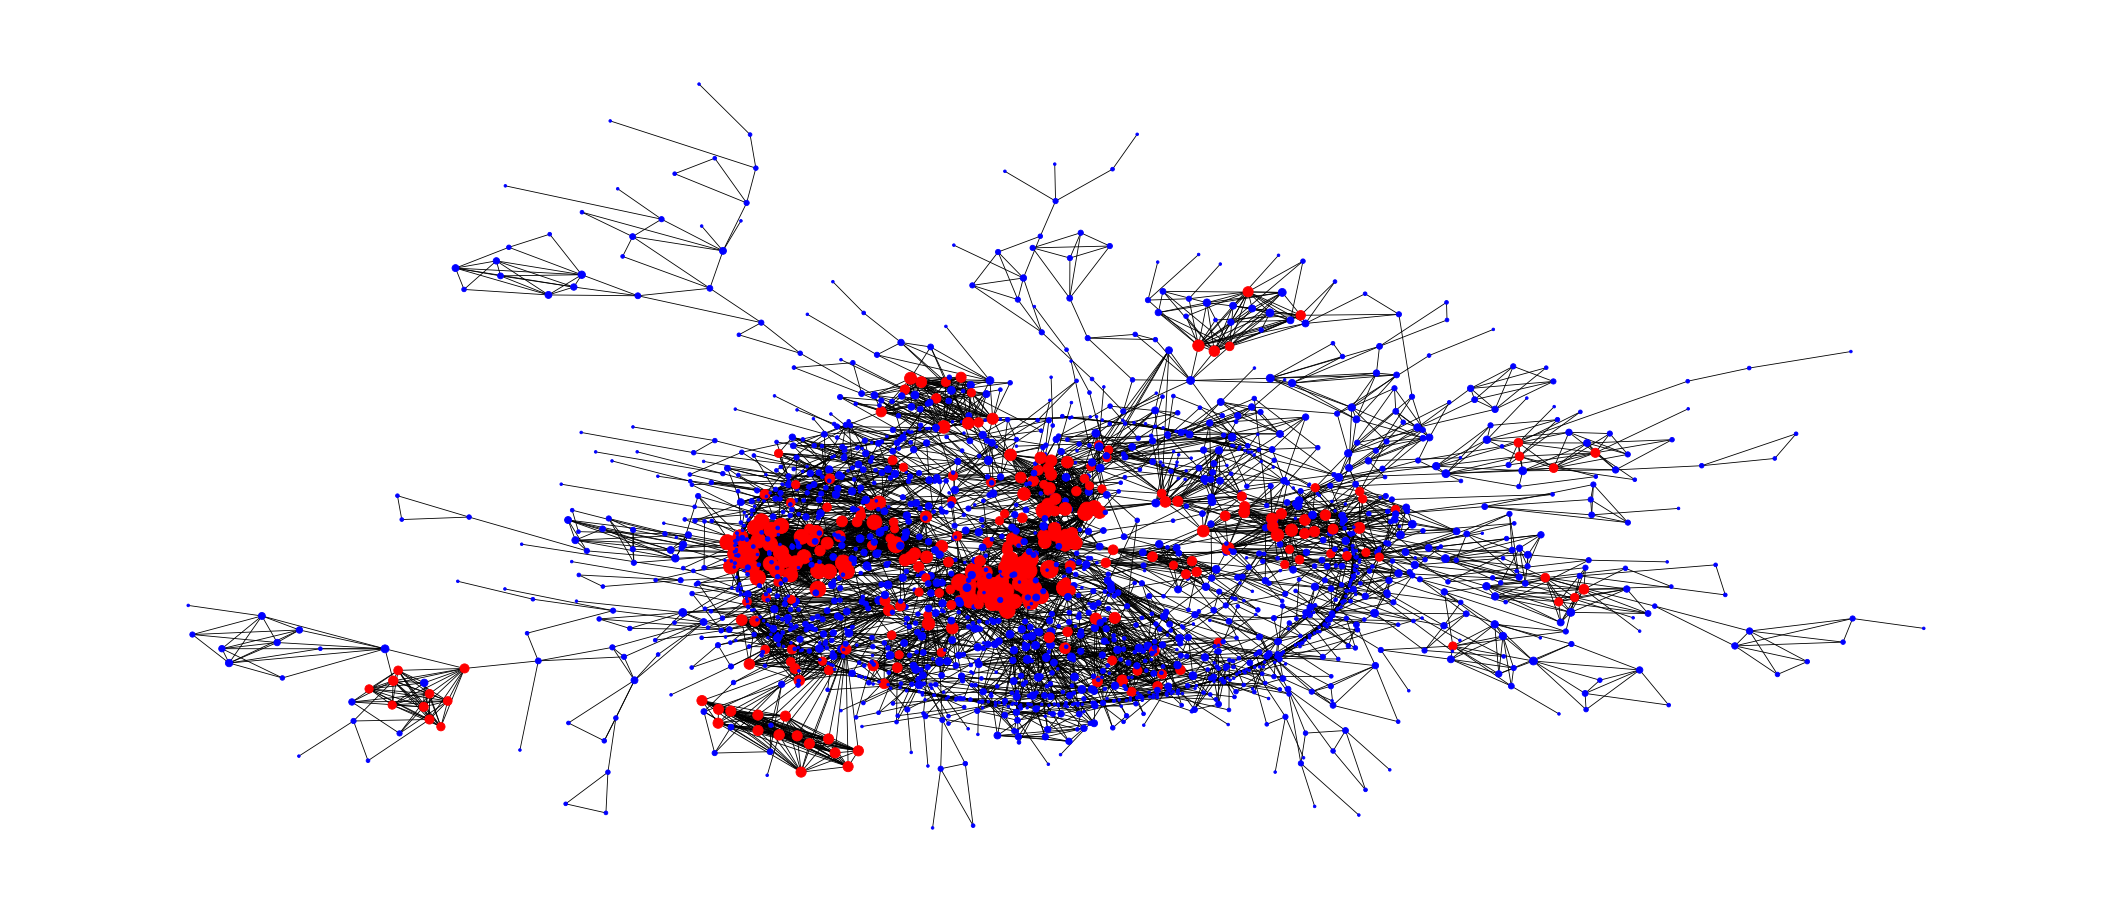

In [85]:
draw_news_graph(G=data_graph, freqs=title_frequency, persons=pairwise_connections)

## Меры всякие

betweenness_centrality

In [86]:
ct = nx.betweenness_centrality(data_graph, weight='similarity')
sorted(ct.items(), key=lambda x: x[1], reverse=True)[:10]

[('У Steam новый рекорд посещаемости — более 35 млн человек',
  0.02656754484307404),
 ('Hogwarts Legacy стала самой продаваемой игрой 2023-го в США',
  0.023757463943306373),
 ('На вершине чарта Steam бодаются выживачи Palworld и Enshrouded',
  0.022155987178502316),
 ("Baldur's Gate III и Alan Wake II — первые по числу номинаций в лонг-листе BAFTA Games Awards",
  0.02137249564286251),
 ('Всё, что показали на Summer Game Fest 2024', 0.021312657003502503),
 ('Всё, что показали на The Game Awards 2023', 0.021248774354625567),
 ('Кросс-плей в Ghost of Tsushima на ПК запустится в «бете»',
  0.02050808120200742),
 ('СМИ: Call of Duty 2024-го появится в Game Pass — впервые в истории серии',
  0.019922921283261407),
 ('Утечка: тиражи игр Sony и возможные детали Marvel’s Spider-Man 3',
  0.019570083763723746),
 ('Sony: 50 млн проданных PS5 и победители голосования в блоге PlayStation по итогам 2023-го',
  0.019513286650269773)]

Кластеризация. Триангуляция

In [87]:
ct = nx.triangles(data_graph)
sorted(ct.items(), key=lambda x: x[1], reverse=True)[:5]

[('Steam Deck и Baldur’s Gate III всё ещё удерживают лидерство в чарте Steam',
  533),
 ('Final Fantasy XIV вернулась в чарт продаж Steam благодаря дополнению Dawntrail',
  515),
 ('Lords of the Fallen борется с Call of Duty на вершине чарта Steam ', 510),
 ('Чарт Steam: Call of Duty, Cyberpunk 2077, For the King II…', 509),
 ('Baldur’s Gate III взлетела на первое место в чарте Steam благодаря скидке',
  507)]

Кластеризация. транзитивность

In [88]:
nx.transitivity(data_graph)

0.7066863137403342

Просто кластеризация

In [89]:
ct = nx.clustering(data_graph, weight='similarity')
sorted(ct.items(), key=lambda x: x[1], reverse=True)[150:170]

[("В Marvel's Spider-Man 2 использовано около 10 % реплик Венома, утверждает актёр",
  1.0),
 ('В Сеть выложили изображения костюмов из Marvel’s Spider-Man 2', 1.0),
 ('Relic сворачивает поддержку консольной Company of Heroes 3', 1.0),
 ('Фанатка купила 4 000 копий Alan Wake. Ни одна из них не работает', 1.0),
 ('Фоторежим для Alan Wake II подготовят весной', 1.0),
 ('Первая песня из саундтрека Alan Wake II — он станет расширением мира игры',
  1.0),
 ('Хоумлендер наслаждается молоком в собственном тизере для Mortal Kombat 1',
  1.0),
 ('CD Projekt: «Микротранзакциям не место в наших одиночных играх»', 1.0),
 ('Журналисты ставят XDefiant средние оценки, но надеются на взлёт игры в будущем',
  1.0),
 ('Хендерсон: число игроков в XDefiant перевалило за 3 миллиона человек', 1.0),
 ('Ролевой боевик Wuthering Waves отправится на ПК и телефоны 22 мая', 1.0),
 ('Вступительный ролик RPG-боевика Wuthering Waves', 1.0),
 ('Открылась регистрация на бета-тест ролевого боевика Wuthering Waves', 1.0

## Настоящая кластеризация

In [90]:
from networkx.algorithms.community import girvan_newman
import itertools
def draw_clusters_graph(G, level: int):
    """
    Function for drawing cluster graph using NetworkX and Matplotlib.

    Parameters:
    G (nx.Graph): Graph to display clusters for.
    communities_level (int): Level of communities to highlight.

    Returns:
    None. Displays clustered graph using Jet colormap.
    """
    # Находим кластеры, используя алгоритм Girvan-Newman
    clusters_generator = girvan_newman(G)
    # Получаем кластеры первого уровня
    blocks = next(itertools.islice(clusters_generator, level, None))

    # Припишем цвет каждому кластеру
    blocks_map = {}
    for idx, block in enumerate(blocks):
        for node in block:
            blocks_map[node] = idx

    # Кладём цвета в список
    colors = [blocks_map[node] for node in G.nodes()]

    # Рисуем граф
    pos = nx.spring_layout(G)
    plt.figure(figsize=(15, 7))
    nx.draw(G, pos, node_color=colors, with_labels=False, node_size=100, cmap=plt.cm.jet)
    plt.show()

Убираем первый уровень

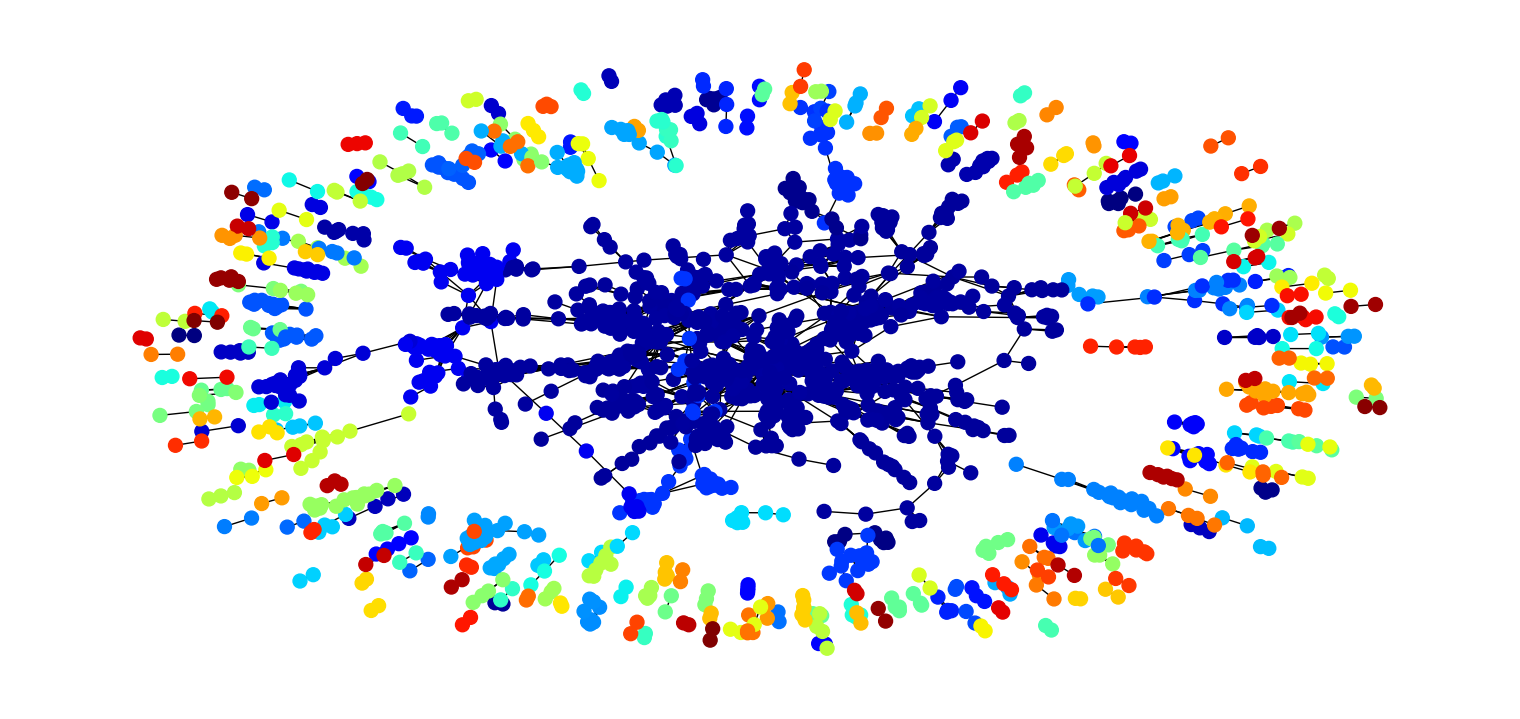

In [91]:
draw_clusters_graph(data_graph, 1)

Убираем пятый уровень (интересно посмотреть, что поменялось)

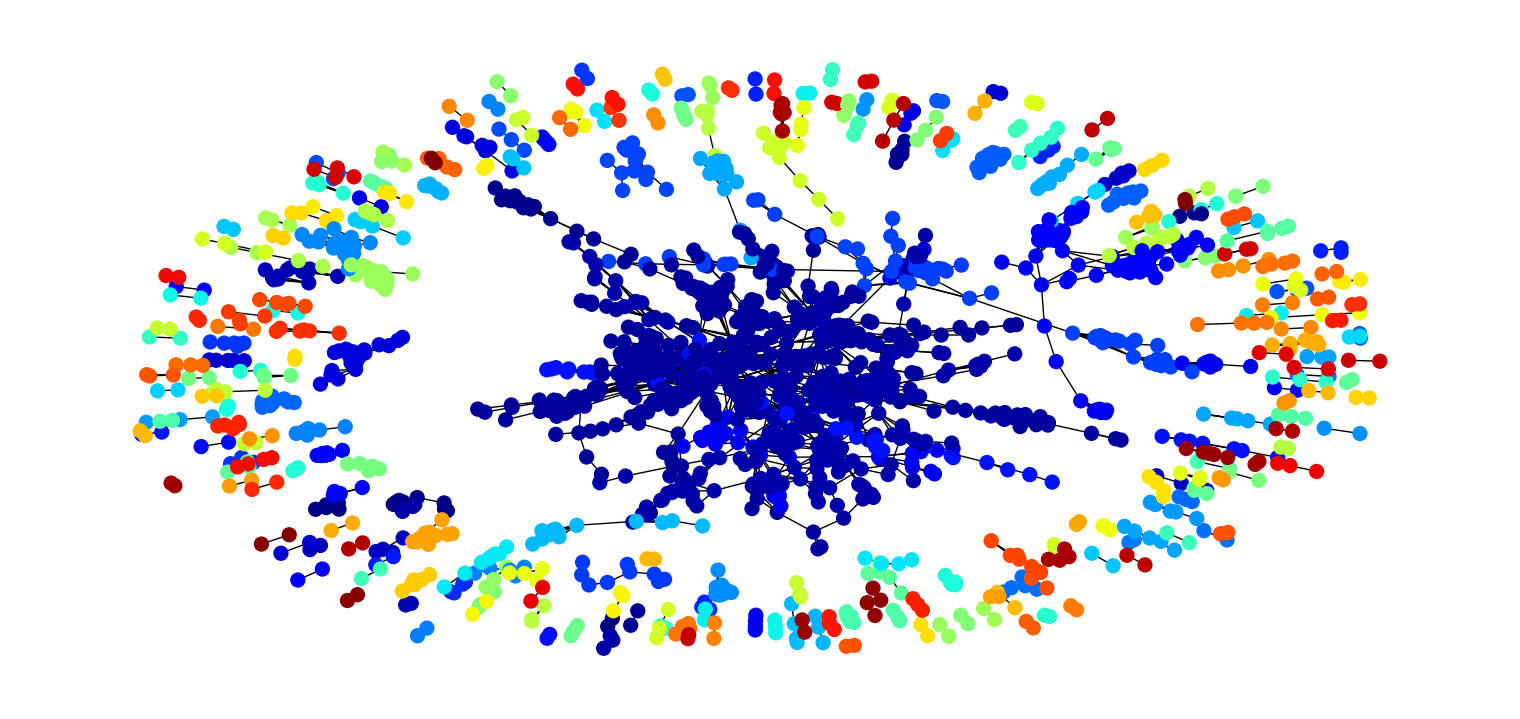

In [92]:
draw_clusters_graph(data_graph, 5)